重要假设：文本中离得越近的词语相似度越高
基于这个假设，word2vec用CBOM和skip-gram来计算词向量矩阵
CBOW 用上下文来预测中心词
skip-gram 用中心词来预测上下文

CBOW和skip-gram两种架构的重点在于得到Q矩阵 softmax(w1(x*Q) + b1)，
没有激活函数
CBOW: 一个老师告诉多个学生，Q矩阵怎么变
skip-gram: 多个老师告诉一个学生，Q矩阵怎么变

In [2]:
import jieba
import re
import numpy as np
from sklearn.decomposition import PCA
import gensim
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import matplotlib

# 分词

In [3]:
with open('./datas/sanguo.txt', 'r', encoding='utf-8') as fr:
    lines = fr.readlines()
res = []
for line in lines:
    # 精准模式
    seg_generator = jieba.cut(line, cut_all=False)
    words = []
    for i in seg_generator:
        # 去掉标点符号
        i = re.sub("[\s+\.\!\/_,$%^*(+\"\'””《》]+|[+——！，。？、~@#￥%……&*（）：；‘]+", "", i)
        if len(i) > 0:
            words.append(i)
    if len(words) > 0:
        res.append(words)

# 打印前五行的分行结果
print(res[:5])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\weihu\AppData\Local\Temp\jieba.cache
Loading model cost 0.478 seconds.
Prefix dict has been built successfully.


[['三国演义', '上卷'], ['罗贯中'], ['滚滚', '长江', '东', '逝水', '浪花', '淘尽', '英雄', '是非成败', '转头', '空', '青山', '依旧', '在', '几度', '夕阳红'], ['白发', '渔樵', '江渚上', '惯看', '秋月春风', '一壶', '浊酒', '喜相逢', '古今', '多少', '事', '都', '付笑谈', '中'], ['--', '调寄', '临江仙']]


# 模型训练

In [8]:
model = Word2Vec(res, 
                 vector_size=20,
                 window=2,
                 min_count=3,
                 epochs=7,
                 negative=10,
                 sg=1)
print("孔明的词向量: \n", model.wv.get_vector('孔明'))
print("\n和孔明相关性最高的前20个词语: ")
model.wv.most_similar('孔明', topn=20)

孔明的词向量: 
 [ 0.36012572 -0.34929478  0.53239405  0.06186799  0.5442623  -0.5561497
  0.56862706  1.2797017  -0.14750677  1.0139508   0.56518215 -0.20781064
  0.05258548 -0.88182634  0.74887806  0.5623414   0.36879233 -0.0081
 -0.76679754 -0.557648  ]

和孔明相关性最高的前20个词语: 


[('玄德', 0.9341393709182739),
 ('周瑜', 0.8975896239280701),
 ('先主', 0.8953267931938171),
 ('关公', 0.8888790011405945),
 ('使者', 0.8704742193222046),
 ('庞统', 0.8644275665283203),
 ('孙权', 0.8632310628890991),
 ('孙夫人', 0.8541097044944763),
 ('维', 0.851658284664154),
 ('陆逊', 0.8509328961372375),
 ('后主', 0.8417274355888367),
 ('鲁肃', 0.8408738374710083),
 ('吕布', 0.8391540050506592),
 ('袁术', 0.8359187841415405),
 ('门吏', 0.8351572155952454),
 ('心中', 0.8344523310661316),
 ('孟获', 0.8324311971664429),
 ('钟会', 0.8318498134613037),
 ('魏主', 0.8316643238067627),
 ('二嫂', 0.8248177170753479)]

# 可视化

In [15]:
# 将词向量投影到二维空间
raw_wordvec = []
word2ind = {}
print(type(model.wv), len(model.wv))
for i, w in enumerate(model.wv.index_to_key):
    raw_wordvec.append(model.wv[w])
    word2ind[w] = i
raw_wordvec = np.array(raw_wordvec)
X_reduced = PCA(n_components=2).fit_transform(raw_wordvec)
print(raw_wordvec.shape)
print(X_reduced.shape)

<class 'gensim.models.keyedvectors.KeyedVectors'> 12481
(12481, 20)
(12481, 2)


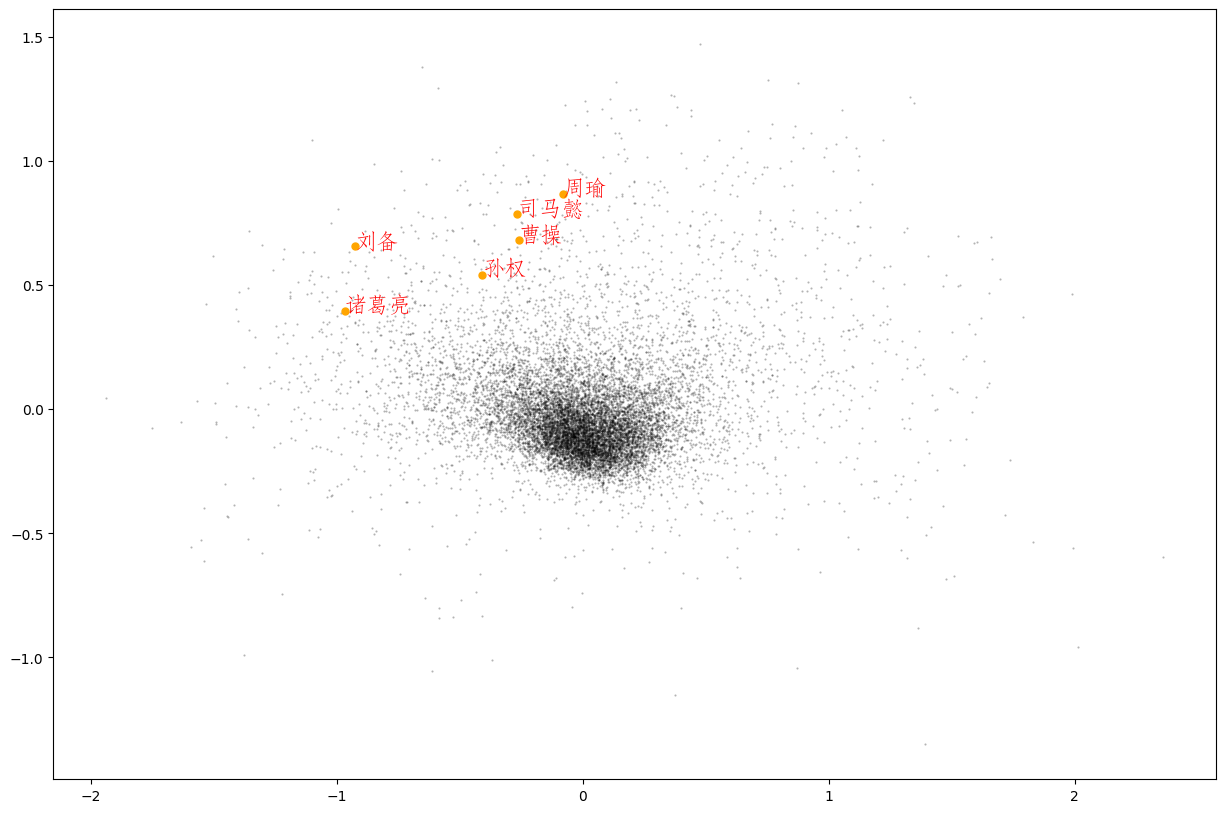

In [18]:
# 绘制所有单词向量的二维空间投影
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.set_facecolor('white')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.',
        markersize=1, alpha=0.3, color='black')

# 绘制几个特出单词的向量
words = ['孙权', '刘备', '曹操', '周瑜', '诸葛亮', '司马懿','汉献帝']

# 设置中文字体
zhfont1 = matplotlib.font_manager.FontProperties(fname='./datas/华文仿宋.ttf', size=16)
for w in words:
    if w in word2ind:
        ind = word2ind[w]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'orange',markersize=10)
        plt.text(xy[0], xy[1], w, fontproperties = zhfont1, alpha = 1, color = 'red')

# 类比关系实验

In [19]:
words = model.wv.most_similar(positive=['玄德', '曹操'],
                              negative=['孔明'])
words

[('司马懿', 0.9145528674125671),
 ('袁绍', 0.8873563408851624),
 ('荆州', 0.8840092420578003),
 ('冀州', 0.8792494535446167),
 ('孙权', 0.8766205906867981),
 ('钟会', 0.8722602725028992),
 ('曹真', 0.8694815039634705),
 ('袁尚', 0.8617338538169861),
 ('袁术', 0.8612008690834045),
 ('吴侯', 0.8584926724433899)]

In [23]:
words = model.wv.most_similar(positive=['曹操', '蜀'],
                              negative=['魏'])
words

[('袁绍', 0.7172755599021912),
 ('五路', 0.7031382918357849),
 ('早', 0.6892849206924438),
 ('吴兵', 0.6682692170143127),
 ('三路', 0.6602693200111389),
 ('魏兵', 0.6521780490875244),
 ('钟会', 0.6480148434638977),
 ('司马懿引', 0.6471112966537476),
 ('曹仁', 0.6456460952758789),
 ('马报', 0.6428967118263245)]